# Movie Sentiment Analysis

Use PyTorch to learn how to do basic movie sentiment analysis

## References

* https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
* https://github.com/hunkim/PyTorchZeroToAll
* https://github.com/clairett/pytorch-sentiment-classification
* https://machinelearningmastery.com/applications-of-deep-learning-for-natural-language-processing/
* https://github.com/a7b23/text-classification-in-pytorch-using-lstm
* https://github.com/udacity/deep-learning/blob/master/sentiment-rnn/Sentiment_RNN_Solution.ipynb
* https://github.com/ritchieng/the-incredible-pytorch

In [1]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm_notebook

## Preprocess

1. Inspect words
    1. Get raw word counts
    2. Find frequent and infrequent words
        1. Remove spaces
        2. Remove punucations
        3. Remove emails
        4. Remove urls
    3. Remove infrequent or too frequent words
2. Inspect reviews
    * Decide correct review length within a reasonable size otherwise will take too long

### Inspect Words

#### Get raw word counts

In [2]:
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'textcat'])
words = defaultdict(lambda: 0)

def clean_doc(doc):
    for token in doc:
        ignore = (token.is_punct or
            token.is_space or token.like_email or
                 token.like_url)
        if ignore:
            continue
        words[token.text] += 1
    return doc
    
nlp.add_pipe(clean_doc)

with open('./reviews.txt', 'r') as file:
    for raw_review in tqdm_notebook(file):
        result = nlp(raw_review)

#### Find frequent and infrequent words

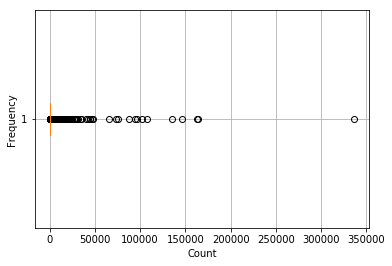

In [3]:
words_sorted = sorted(words.items(), key=lambda item: item[1])
word_counts = np.array(list(map(lambda word: word[1], words_sorted)))
plt.grid(True)
plt.boxplot(word_counts, vert=False)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [4]:
pd.DataFrame(word_counts).describe()

,0
count,74023.000000
mean,81.369250
std,2046.978191
min,1.000000
25%,1.000000
50%,3.000000
75%,11.000000
max,336713.000000


### Remove words of a certain bound

In [5]:
upper_bound = np.percentile(word_counts, 99)
lower_bound = np.percentile(word_counts, 40)
remaining_words = dict(filter(lambda word: word[1] >= lower_bound and word[1] < upper_bound, words_sorted))

In [6]:
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner', 'textcat'])

def final_doc(doc):
    result = ''
    for token in doc:
        ignore = (token.is_punct or
            token.is_space or token.like_email or
                 token.like_url or (token.text not in remaining_words))
        if ignore:
            continue
        result += token.text + ' '
    return result

nlp.add_pipe(final_doc)

shortened_reviews = []
with open('./reviews.txt', 'r') as file:
    for raw_review in tqdm_notebook(file):
        shortened_reviews.append(nlp(raw_review))

## Inspect Reviews  

### Find review length

In [7]:
review_lengths = np.array(list(map(lambda rev: len(rev), shortened_reviews)))

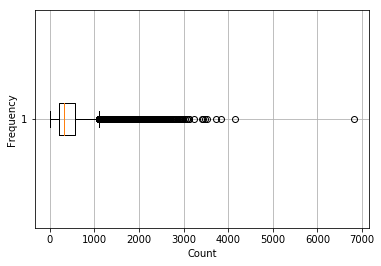

In [8]:
plt.grid(True)
plt.boxplot(review_lengths, vert=False)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [9]:
pd.DataFrame(review_lengths).describe()

,0
count,25000.000000
mean,458.325960
std,412.386458
min,0.000000
25%,200.750000
50%,320.000000
75%,562.000000
max,6823.000000


In [10]:
lower_review_bound = np.percentile(review_lengths, 25)
lower_review_bound

200.75

In [11]:
upper_review_bound = np.percentile(review_lengths, 91)
upper_review_bound

1032.0

#### Word to Number Mapping

In [12]:
word_mapping = {}
word_index = 1
REVIEW_LENGTH = 200
reviews_as_words = []
for review in tqdm_notebook(shortened_reviews):
    review_words = review.split(' ')[:REVIEW_LENGTH]
    for review_word in review_words:
        if review_word not in word_mapping:
            word_mapping[review_word] = word_index
            word_index += 1
    reviews_as_words.append(review_words)

In [13]:
word_index

45579

### Reviews as indexes

In [14]:
reviews_as_indexes = []
for review_words in tqdm_notebook(reviews_as_words):
    numerical_review = []
    for review_word in review_words:
        if review_word in word_mapping:
            numerical_review.append(word_mapping[review_word])
    numerical_review = np.array(numerical_review)
    reviews_as_indexes.append(np.pad(numerical_review, (0, REVIEW_LENGTH - len(numerical_review)), mode='constant', constant_values=0))
reviews_as_indexes = np.array(reviews_as_indexes)

### Review Classifications

In [30]:
review_classifications = []
with open('./labels.txt', 'r') as file:
    for classify in file:
        if 'positive' in classify:
            review_classifications.append(1)
        else:
            review_classifications.append(0)
review_classifications = np.array(review_classifications)

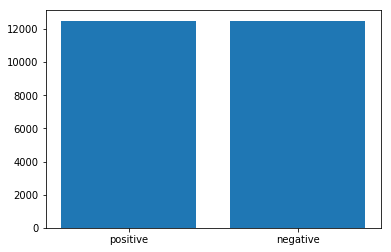

In [16]:
review_positive = review_classifications[review_classifications[:] == 1]
review_negative = review_classifications[review_classifications[:] == 0]
review_positive_count = review_positive.shape[0]
review_negative_count = review_negative.shape[0]
plt.bar(['positive', 'negative'], [review_positive_count, review_negative_count])
plt.show()

In [17]:
print(f'Positive reviews {review_positive_count}')
print(f'Negative reviews {review_negative_count}')

Positive reviews 12500
Negative reviews 12500


### Save Work

### Build a training set / test set

# Deep Learning

* Can resuse embeddings so people already build the similarity table
    * https://www.quora.com/What-is-the-embedding-layer-in-LSTM-long-short-term-memory
* See train.py for full code